# Code for experimenting with impelementing periodicity

In [1]:
import scipy.io
import numpy as np
import auxfunctions as aux

Z, C, W, m = aux.load_data_from_msgpack('./data/SG_data_16071_30.msgpack')

initialdata = scipy.io.loadmat('./data/1_step_solutions.mat')

Z_test_1 = initialdata['Z'][:,:,0]
Z_test_2 = initialdata['Z'][:,:,1]
Z_test_3 = initialdata['Z'][:,:,2]
w_test_1 = initialdata['w'][:,0]
w_test_2 = initialdata['w'][:,1]
w_test_3 = initialdata['w'][:,2]
Z0_test = initialdata['Z0']
C_test_1 = initialdata['C'][:,:,0]
C_test_2 = initialdata['C'][:,:,1]
C_test_3 = initialdata['C'][:,:,2]

bx = [-1000000.0, -5112.42651350665, 1000000.0, 5112.42651350665]

print(np.shape(Z))

KeyboardInterrupt: 

In [ ]:
def check_distances(data):
    num_timesteps, num_particles, _ = data.shape
    threshold = 1/num_particles
    
    for t in range(num_timesteps):
        # Compute pairwise distances for each timestep
        # This is a simplified and memory-efficient approach for demonstration purposes
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                if np.linalg.norm(data[t, i] - data[t, j]) <= threshold:
                    return False  # Found a pair with distance <= threshold
        print('Checked timestep', t)
    return True  # All distances are > threshold

# Check if all distances meet the criterion
result = check_distances(Z)
print(f"All pairwise distances are greater than the threshold: {result}")

In [ ]:
import optimaltransportsolver as ots

Z = Z_test_2
D = ots.make_domain(bx, True, False)
w0 = w_test_2
per_tol = 1e-3

sol = ots.ot_solve(D, Z, w0, per_tol, True, False, bx, solver = 'Scipy', debug = True)

In [ ]:
import optimaltransportsolver as ots
from pysdot import PowerDiagram
import pyvista as pv

Z = Z_test_2
domain = ots.make_domain(bx, False, False)
w0 = sol[1]
C = sol[0]

pd = PowerDiagram( positions = Z, domain = domain, weights = w0 )

filename = 'pb.vtk'
pd.display_vtk( filename )

# Mass of cells
colours=pd.integrals()

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_colours = colours[grid.cell_data['num'].astype(int)]
grid.cell_data['colours']=cell_colours

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid) #, clim=[minvel, maxvel])

plotter.set_scale(xscale=0.1, yscale=10)

# Set the camera for 2D view
plotter.camera_position = 'xy'

# Render the frame
plotter.show()

In [ ]:
import matplotlib.pyplot as plt

#Plot the seeds

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(C_test_3[:,0], C_test_3[:,1], color= 'red', s = 8)
ax.scatter(C[3,:,0], C[3,:,1], color= 'blue', s = 8)
# ax.set_xlim([-1.25e6, 1.25e6])
# ax.set_ylim([-0.25e7, 3e7])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
diff = np.linalg.norm(Z0_test.astype(float) - Z[0].astype(float), axis = 1) ** 2

print(Z0_test[100]- Z[0,100])

NameError: name 'Z' is not defined

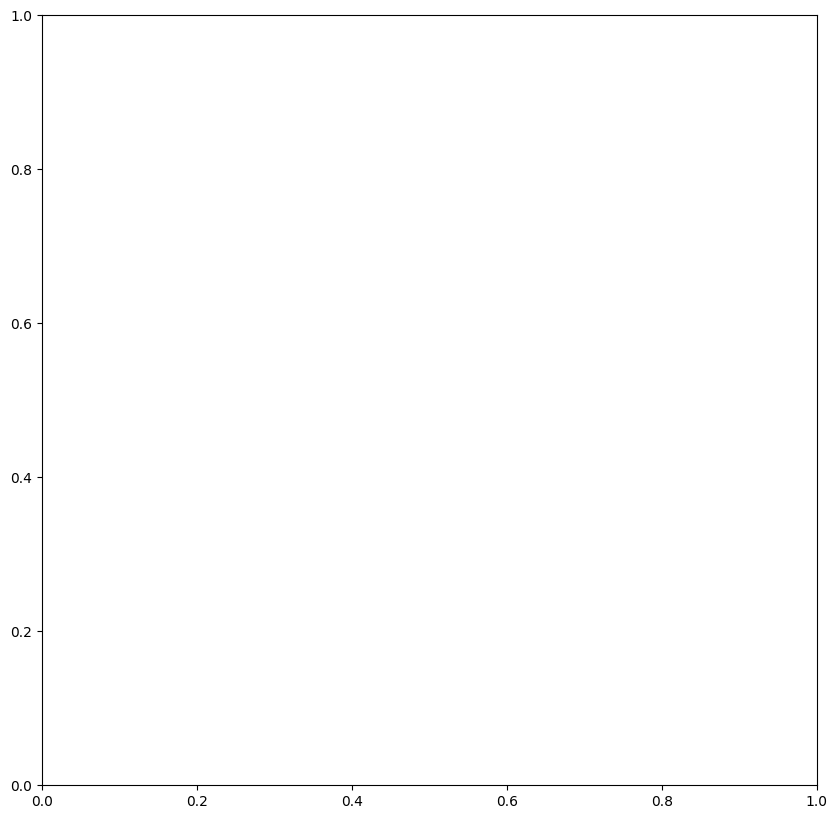

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#Plot the centroids

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z[:,0], Z[:,1], color= 'blue', s = 8)
ax.set_xlim([np.max(Z[:,0]), np.min(Z[:,0])])
ax.set_ylim([np.max(Z[:,1]), np.min(Z[:,1])])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
import scipy.io

data = scipy.io.loadmat('./data/LongData.mat')

C_data = data['C'][:,:,:] 
Z_data = data['Z'][:,:,:] 
w_data = data['w'][:,:] 

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

#Plot the centroids
T = 248 #283 is max

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(C_data[:, 0, T], C_data[:, 1, T], color= 'blue', s = 8)
ax.set_xlim([np.max(C_data[:, 0, T]), np.min(C_data[:, 0, T])])
ax.set_ylim([np.max(C_data[:, 1, T]), np.min(C_data[:, 1, T])])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

# Check that the periodic and non-periodic transport costs are being correctly computed

In [3]:
import numpy as np
from pysdot import OptimalTransport
from pysdot.domain_types import ConvexPolyhedraAssembly

box = [0, -0.5, 1, 0.5] # Fundamental Domain
Z = np.array([[0.25, 0], [0.5, 0]])
psi0 = np.zeros(shape = (2,))

#Constructs a domain to be passed to the laguerre functions
def make_domain(box, PeriodicX, PeriodicY):
    """
    Constructs a domain for the optimal transport problem.

    Parameters:
        box (list/tuple): Domain boundaries [xmin, ymin, zmin, xmax, ymax, zmax].
        PeriodicX, PeriodicY (bool): Periodicity flags for each axis.

    Returns:
        ConvexPolyhedraAssembly: Domain object for the optimal transport solver.
    """
    domain = ConvexPolyhedraAssembly()
    Lx, Ly = [box[i+2] - box[i] for i in range(2)]

    # Calculate the offset and size for each dimension based on periodicity
    size = [2 * Lx if PeriodicX else box[2], 
            2 * Ly if PeriodicY else box[3]]

    offset = [-Lx if PeriodicX else box[0], 
              -Ly if PeriodicY else box[1]]

    domain.add_box(offset, size)
    return domain

#Solve the Optimal transport problem and return the centroids and weights
def ot_solve(domain, Y, psi0, err_tol, PeriodicX, PeriodicY, box, solver = 'Petsc', debug = False):
    """
    Solves the optimal transport problem and returns centroids, weights, and cell masses.

    Parameters:
        domain (ConvexPolyhedraAssembly): Source domain of the optimal transport problem.
        Y (numpy.ndarray): Seed positions.
        psi0 (numpy.ndarray): Initial weight guesses.
        err_tol (float): Error tolerance for cell mass.
        PeriodicX, PeriodicY (bool): Periodicity flags.
        box (list/tuple): Domain boundaries.
        solver (str): Linear solver to use ('Petsc' or 'Scipy').
        debug (bool): Flag to enable debugging information.

    Returns:
        tuple: Centroids, optimal weights, and cell masses after optimization.
    """
    N = Y.shape[0]
    Lx, Ly = [abs(box[i+2] - box[i]) for i in range(2)]
    ot = OptimalTransport(positions=Y, weights=psi0, masses=Lx * Ly * np.ones(N) / N, domain=domain, linear_solver=solver)
    ot.set_stopping_criterion(err_tol, 'max delta masses')

    # Adding replications based on periodicity
    for x in range(-int(PeriodicX), int(PeriodicX) + 1):
        for y in range(-int(PeriodicY), int(PeriodicY) + 1):
            if x != 0 or y != 0:
                ot.pd.add_replication([Lx * x, Ly * y])

    premass = ot.get_masses() if debug else None
    ot.adjust_weights()
    psi = ot.get_weights()
    postmass = ot.pd.integrals()
    transportcost = ot.pd.second_order_moments()

    if debug:
        print('Difference in target and final mass', np.linalg.norm(premass - postmass) / np.linalg.norm(premass))

    return ot.pd.centroids(), psi, postmass, transportcost

# Construct the domain for our test probelm
D1 = make_domain(box, False, False)
D2 = make_domain(box, True, False)

# Solve the optimal tranport problem
sol1 = ot_solve(D1, Z, psi0, 1e-3, False, False, box)
sol2 = ot_solve(D2, Z, psi0, 1e-3, True, False, box)

# Extract and check the total transport cost
print('Non-Periodic Transport Cost:', sum(sol1[3]), 'Periodic Transport Cost:', sum(sol2[3]))

Non-Periodic Transport Cost: 0.13541666666666666 Periodic Transport Cost: 0.11979166666666666
